<a href="https://colab.research.google.com/github/taranaalex/MLPNS_ATarana/blob/main/assess_TS_classification_w_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Timeseries classification with a Transformer model

**Author:** [Theodoros Ntakouris](https://github.com/ntakouris)<br>
**Date created:** 2021/06/25<br>
**Last modified:** 2021/08/05<br>
**Description:** This notebook demonstrates how to do timeseries classification using a Transformer model.

THIS KERAS EXAMPLE OF APPLICATION OF TRANSFORMERS TO TIME SERIES ANALYSIS IS **WRONG**

My student Willow Fox Fortino found that out... 

## Introduction

This is the Transformer architecture from
[Attention Is All You Need](https://arxiv.org/abs/1706.03762),
applied to timeseries instead of natural language.

This example requires TensorFlow 2.4 or higher.

## Load the dataset

We are going to use the same dataset and preprocessing as the
[TimeSeries Classification from Scratch](https://keras.io/examples/timeseries/timeseries_classification_from_scratch)
example.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd /content/drive/MyDrive/MLPNS2023/

/content/drive/MyDrive/MLPNS2023


In [4]:
# install 'transformers' in order to load trained models from 'Huggin Face'
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import numpy as np


def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

# create train and test set
x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

# change shape to the sets: x_train, x_test are 1-dim arrays but I want to
# turn them into matrices of the same shape as y_train, y_test respectively
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

n_classes = len(np.unique(y_train))

# 'np.random.permutation()' returns a sort of 'permutation seed' from which I
# will be able to generate actual permutations of arrays
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

# turns all the -1 values of y_train, y_test into 0
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

# TASK 1: 

the author provide no data exploration. That is not acceptable. Explore the data

In [9]:
import pylab as pl

In [10]:
x_train.shape

(3601, 500, 1)

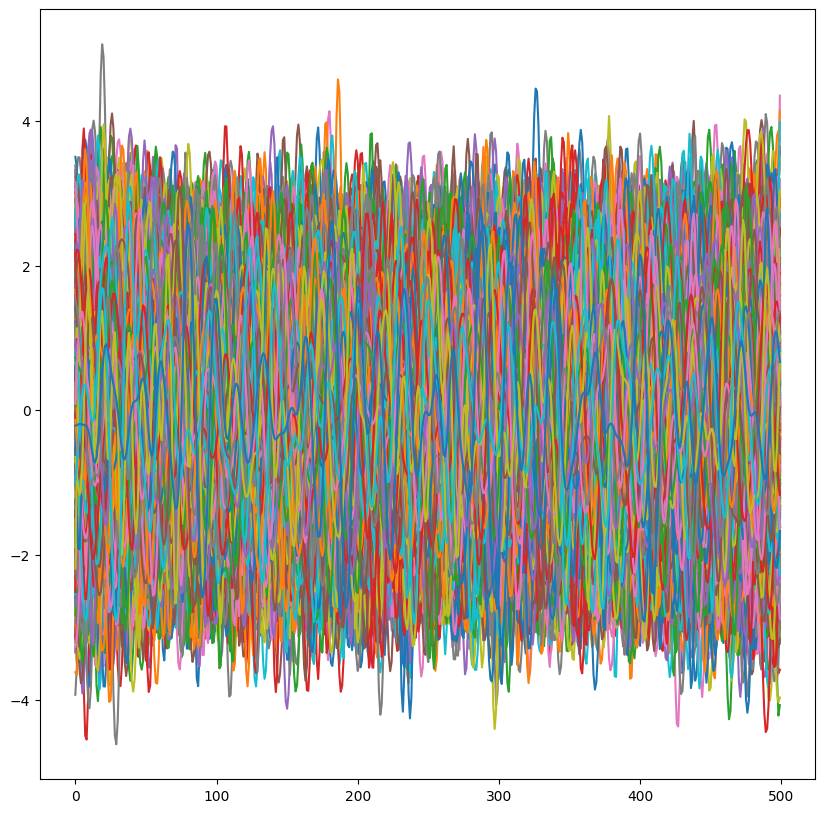

In [11]:
ax = pl.figure(figsize=(10,10)).add_subplot(111)

for ii in range(x_train.shape[0]):
  ax.plot(x_train[ii][:])

In [15]:
np.unique(y_train)

array([0, 1])

## Build the model

Our model processes a tensor of shape `(batch size, sequence length, features)`,
where `sequence length` is the number of time steps and `features` is each input
timeseries.

You can replace your classification RNN layers with this one: the
inputs are fully compatible!

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

We include residual connections, layer normalization, and dropout.
The resulting layer can be stacked multiple times.

The projection layers are implemented through `keras.layers.Conv1D`.

In [13]:

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


The main part of our model is now complete. We can stack multiple of those
`transformer_encoder` blocks and we can also proceed to add the final
Multi-Layer Perceptron classification head. Apart from a stack of `Dense`
layers, we need to reduce the output tensor of the `TransformerEncoder` part of
our model down to a vector of features for each data point in the current
batch. A common way to achieve this is to use a pooling layer. For
this example, a `GlobalAveragePooling1D` layer is sufficient.

In [14]:

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)


## Train and evaluate

In [47]:
# in order to procede it is necessary to import the file 'transformer_h4_model.h5' in the MLPNS_2023 folder

In [15]:
input_shape = x_train.shape[1:]

"""
create a model with :
4 multiattention heads each size 256, 
4 transformer blocks
4 neurons in the convolutional layers
128 neurons in the feed forward layers
dropout 40% on the transformer layers
dropout 25% on the feed forward layers

compile it with a sparse_categorical_crossentropy,
choose the kearas adam optimizer with a learning rate of 1e-4
monitor the sparse_categorical_accuracy metric
"""

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)

model = keras.models.load_model('transformer_h4_model.h5')
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, 
                                           restore_best_weights=True)]



Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 500, 1)]     0           []                               
                                                                                                  
 layer_normalization_32 (LayerN  (None, 500, 1)      2           ['input_5[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_16 (Multi  (None, 500, 1)      7169        ['layer_normalization_32[0][0]', 
 HeadAttention)                                                   'layer_normalization_32[0][0]'] 
                                                                                            

In [16]:
import pickle

In [48]:
# in order to procede it is necessary to import the file 'history_h4.h5' in the MLPNS_2023 folder

In [38]:
with open('transformer_h4_history', 'rb') as file_pi:
    history_4h = pickle.load(file_pi)
   

In [58]:
history_4h

{'loss': [1.0337411165237427,
  0.90003502368927,
  0.8167863488197327,
  0.7477308511734009,
  0.7320464849472046,
  0.7002580165863037,
  0.6536239385604858,
  0.6401299834251404,
  0.6098744869232178,
  0.5881328582763672,
  0.5780110359191895,
  0.5507245659828186,
  0.5185609459877014,
  0.5108712315559387,
  0.506050169467926,
  0.4868743121623993,
  0.479048490524292,
  0.4650138020515442,
  0.45568543672561646,
  0.45541855692863464,
  0.44078242778778076,
  0.4272463917732239,
  0.42579931020736694,
  0.42268311977386475,
  0.41479653120040894,
  0.4121769666671753,
  0.3971201181411743,
  0.3912397623062134,
  0.381257027387619,
  0.3809517025947571,
  0.3795774281024933,
  0.3757326304912567,
  0.3706333041191101,
  0.3628022372722626,
  0.3525751829147339,
  0.3406672477722168,
  0.34150999784469604,
  0.3340880870819092,
  0.3322702646255493,
  0.33264705538749695,
  0.3241068422794342,
  0.32381024956703186,
  0.31487905979156494,
  0.3102208971977234,
  0.313512742519378

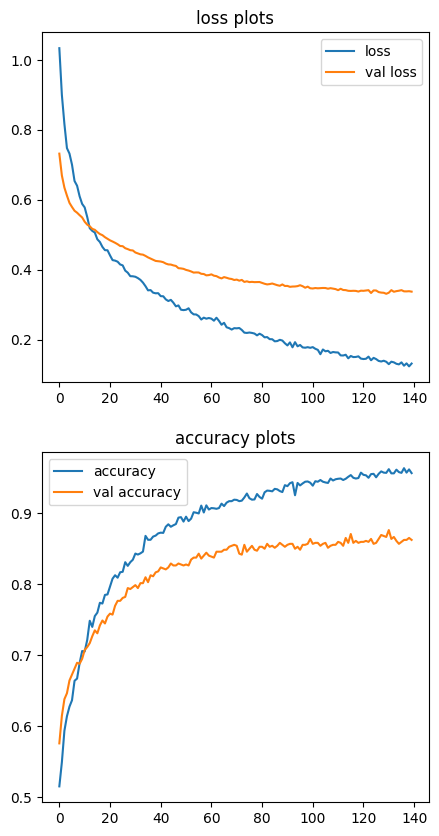

In [104]:
fig, ax = pl.subplots(2, figsize=(5,10))

ax[0].set_title('loss plots')
ax[0].plot(history_4h['loss'])
ax[0].plot(history_4h['val_loss'])
ax[0].legend(['loss','val loss'])

ax[1].set_title('accuracy plots')
ax[1].plot(history_4h['sparse_categorical_accuracy'])
ax[1].plot(history_4h['val_sparse_categorical_accuracy'])
ax[1].legend(['accuracy','val accuracy'])

## Conclusions

Official version: In about 110-120 epochs (25s each on Colab), the model reaches a training
accuracy of ~0.95, validation accuracy of ~84 and a testing
accuracy of ~85, without hyperparameter tuning. And that is for a model
with less than 100k parameters. Of course, parameter count and accuracy could be
improved by a hyperparameter search and a more sophisticated learning rate
schedule, or a different optimizer.

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/timeseries_transformer_classification) and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/timeseries_transformer_classification).

**Reality** these transformer blocks are not doing anything! 
- there is no positional encoding
- the time series are 1D and its not clear that the performance holds going from multivariate (tockenized) to univariate


In [5]:
import os
os.getcwd()

'/content/drive/MyDrive/MLPNS2023'

In [6]:
from transformers import AutoModel

In [21]:
input_shape = x_train.shape[1:]

"""
create another model with :
1 multiattention head size 256, 
0 transformer blocks
4 neurons in the convolutional layers
128 neurons in the feed forward layers
dropout 40% on the transformer layers
dropout 25% on the feed forward layers

compile it with a sparse_categorical_crossentropy,
choose the kearas adam optimizer with a learning rate of 1e-4
monitor the sparse_categorical_accuracy metric
"""

model = build_model(
    input_shape,
    head_size=256,
    num_heads=1,
    ff_dim=4,
    num_transformer_blocks=0,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)



model = AutoModel.from_pretrained('keras-io/timeseries_transformer_classification')
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, 
                                           restore_best_weights=True)]

   

OSError: ignored

print accuracy and loss

plot the history .... what do you see?